In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import re

PATH = "Project-III/data/sherlock-holm.es_stories_plain-text_advs.txt"

# Read the text file
with open(PATH, 'r', encoding='utf-8') as file:
    text = file.read()



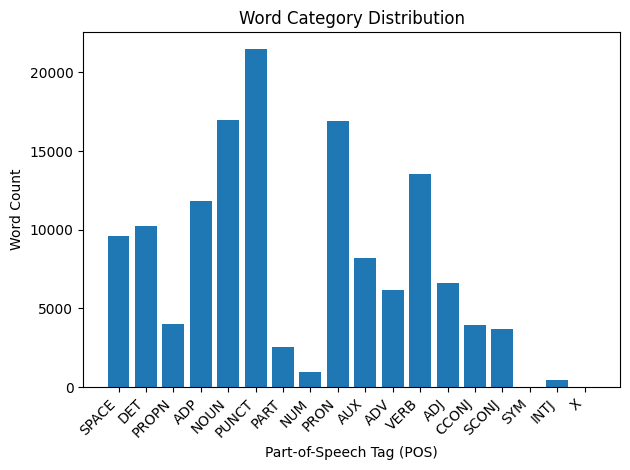

In [2]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load spaCy model (download the desired model first if not installed)
nlp = spacy.load("en_core_web_sm")


def categorize_words(text):
  """
  Analyzes text using spaCy and categorizes words by part-of-speech (POS) tag.

  Args:
      text (str): The text to be analyzed.

  Returns:
      dict: A dictionary where keys are POS tags and values are word counts.
  """
  doc = nlp(text)
  word_counts = Counter()
  for token in doc:
    word_counts[token.pos_] += 1
  return word_counts


def plot_word_counts(word_counts):
  """
  Creates a bar chart showing the count of each word category.

  Args:
      word_counts (dict): A dictionary containing word categories (POS tags) as keys and their counts as values.
  """
  labels = list(word_counts.keys())
  counts = list(word_counts.values())
  plt.bar(labels, counts)
  plt.xlabel("Part-of-Speech Tag (POS)")
  plt.ylabel("Word Count")
  plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
  plt.title("Word Category Distribution")
  plt.tight_layout()
  plt.show()


# Read the book text (replace with your method of reading the book)
with open("Project-III/data/sherlock-holm.es_stories_plain-text_advs.txt", "r", encoding="utf-8") as f:
  book_text = f.read()

# Analyze and categorize words
word_counts = categorize_words(book_text)

# Plot the word counts
plot_word_counts(word_counts)

In [3]:
def calculate_flesch_kincaid(text):

  # Split text into sentences and words
  sentences = text.split(".")
  sentences = [sentence.strip() for sentence in sentences if sentence]  # Remove empty sentences
  words = text.split()

  # Count words and sentences
  num_words = len(words)
  num_sentences = len(sentences)

  # Calculate Flesch-Kincaid factors
  avg_words_per_sentence = num_words / num_sentences if num_sentences > 0 else 0
  avg_syllables_per_word = count_syllables(words) / num_words if num_words > 0 else 0

  # Calculate Flesch-Kincaid Grade Level
  flesch_kincaid_score = 0.39 * (avg_words_per_sentence / 11.8) + 16.9 * (avg_syllables_per_word / 0.4)

  return flesch_kincaid_score

def count_syllables(words):

  num_syllables = 0
  for word in words:
    vowels = "aeiouAEIOU"
    count = 0
    is_previous_vowel = False
    for char in word:
      if char in vowels:
        if not is_previous_vowel:
          count += 1
        is_previous_vowel = True
      else:
        is_previous_vowel = False
    # Add one syllable for words ending in 'e' except for those where 'e' follows a vowel
    if word.endswith("e") and not word[-2] in vowels:
      count += 1
    num_syllables += count
  return num_syllables

# Example usage
text = "This is a sample text to calculate the Flesch-Kincaid Grade Level."
flesch_kincaid_score = calculate_flesch_kincaid(text)
print("Flesch-Kincaid Grade Level:", flesch_kincaid_score)

Flesch-Kincaid Grade Level: 88.70446841294297


In [5]:
def calculate_average_lengths(text):

  # Split text into sentences and words
  sentences = text.split(".")
  sentences = [sentence.strip() for sentence in sentences if sentence]  # Remove empty sentences
  words = text.split()

  # Count words and sentences
  num_words = len(words)
  print(len(sentences))
  num_sentences = len(sentences)

  # Calculate average sentence length
  avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0

  # Calculate average word length (excluding punctuation)
  avg_word_length = sum(len(word) for word in words if word.isalnum()) / num_words if num_words > 0 else 0

  return avg_sentence_length, avg_word_length

# Example usage
text = "This is a sample text to calculate average sentence length and word length."
avg_sentence_length, avg_word_length = calculate_average_lengths(text)
print("Average Sentence Length:", avg_sentence_length)
print("Average Word Length:", avg_word_length)


1
Average Sentence Length: 13.0
Average Word Length: 4.3076923076923075


In [5]:
# Tokenize the text
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words = text.split()
    return words

tokens = tokenize(text)
word_counts = Counter(tokens)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word_to_index = {word: index + 1 for index, word in enumerate(vocab)}
index_to_word = {index + 1: word for index, word in enumerate(vocab)}
total_words = len(word_to_index) + 1

In [6]:
# Create input-output pairs
input_sequences = []
for line in text.split('\n'):
    token_list = [word_to_index[word] for word in tokenize(line) if word in word_to_index]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [7]:
# Pad the sequences
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array([np.pad(seq, (max_sequence_len - len(seq), 0), mode='constant') for seq in input_sequences])

In [8]:
# Split the sequences into input (X) and output (y)
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

# Convert output to one-hot encoded vectors
y = np.array(torch.nn.functional.one_hot(torch.tensor(y), num_classes=total_words))

In [9]:
# Create a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TextDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the model
class NextWordPredictor(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.2):
    super(NextWordPredictor, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.dropout_embed = nn.Dropout(dropout)  # Add dropout after embedding
    self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, dropout=dropout, bidirectional=True, batch_first=True)  # Use Bidirectional LSTM with multiple layers
    self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Adjust output size for Bidirectional LSTM

  def forward(self, sequences):
    embedded = self.embedding(sequences)
    embedded = self.dropout_embed(embedded)
    lstm_out, _ = self.lstm(embedded)
    last_hidden = lstm_out[:, -1, :]  # Select last hidden state from the sequence
    logits = self.fc(last_hidden)
    return logits

model = NextWordPredictor(total_words, 100, 150, total_words)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau

epochs = 200
patience = 5  # Number of epochs to wait for improvement
current_patience = patience
best_loss = float('inf')  # Initialize best loss to a very high value
better_model = model
for epoch in range(epochs):
  # Training loop
  for i, (inputs, labels) in enumerate(dataloader):
    outputs = model(inputs)
    loss = criterion(outputs, labels.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Early stopping
  if loss.item() < best_loss:  # Compare current training loss with best loss
    best_loss = loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()} (Improved)')
    better_model = model
    current_patience = patience  # Restart patience
  else:
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    current_patience -= 1  # Decrement patience counter on no improvement

  # Stop training if patience is 0
  if current_patience == 0:
    print('Early stopping triggered!')
    break

'''
# Optional: Save the best model based on training loss
if best_loss != float('inf'):
  torch.save(model.state_dict(), 'best_model.pt')
'''

In [ ]:
# Generate predictions
def predict_next_words(model, tokenizer, seed_text, next_words):
    for _ in range(next_words):
        token_list = [word_to_index[word] for word in tokenize(seed_text)]
        token_list = np.pad(token_list, (max_sequence_len - len(token_list), 0), mode='constant')
        token_list = torch.tensor(token_list[-max_sequence_len+1:], dtype=torch.long).unsqueeze(0)

        with torch.no_grad():
            predicted = model(token_list).argmax(dim=1).item()

        output_word = index_to_word[predicted]
        seed_text += " " + output_word

    return seed_text

seed_text = "i am"
next_words = 16
print(predict_next_words(better_model, word_to_index, seed_text, next_words))